In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# import os
# import pandas as pd
# import numpy as np

# output_dir = os.path.join(".", "output")  # Path to the output directory
# subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
# subdirs.sort()

# # Create an empty 3D array to store the combined data
# combined_arr = np.empty((len(subdirs), 999, 10))

# # Loop through each subdirectory and load the CSV files
# for i, subdir in enumerate(subdirs):
#     action_filename = os.path.join(subdir, "action.csv")
#     obs_filename = os.path.join(subdir, "obs.csv")

#     # Load the action and obs CSV files
#     action_df = pd.read_csv(action_filename)
#     obs_df = pd.read_csv(obs_filename)

#     # Concatenate the DataFrames horizontally
#     combined_data = pd.concat([action_df, obs_df], axis=1)

#     # Convert combined_data to a 3D array and assign it to combined_arr
#     combined_arr[i] = np.reshape(combined_data.values, (999, 10))

# # Print the shape of combined_arr
# print(combined_arr.shape)


In [4]:
# flattened_arr = combined_arr.reshape(10000, 9990)

In [5]:
# flattened_arr.shape

In [14]:
import torch

combined_df = np.array(combined_arr)
combined_tensor = torch.from_numpy(combined_df)
flattened_tensor = combined_tensor.flatten(start_dim=1)

In [7]:
# # Rename dimensions to 'Seed' and 'Data'
# flattened_tensor.names = ("Seed", "Data")

# # Now flattened_tensor will have dimensions named 'Seed' and 'Data'
# print(flattened_tensor.shape)  # Output: torch.Size([10000, 9990])
# print(flattened_tensor)

In [8]:
# len(flattened_tensor)

In [89]:
import os
import pandas as pd
import numpy as np

output_dir = os.path.join(".", "output")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)
flattened_arr = combined_arr.reshape(10000, 10000)

(10000, 1000, 10)


In [107]:
import torch

# Convert combined_arr to PyTorch Tensor
combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

torch.Size([10000, 1000, 10])


In [ ]:
# import os
# import pandas as pd
# from tqdm import tqdm  # Import tqdm

# output_dir = os.path.join(".", "output")  # Path to the output directory
# subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
# combined_df = pd.DataFrame()

# # Create a tqdm progress bar
# pbar = tqdm(subdirs, desc="Processing subdirectories", unit="subdir")

# for subdir in pbar:
#     action_filename = os.path.join(subdir, "action.csv")
#     obs_filename = os.path.join(subdir, "obs.csv")
#     action_df = pd.read_csv(action_filename)
#     obs_df = pd.read_csv(obs_filename)
#     combined_data = pd.concat([action_df, obs_df], axis=1)
#     if combined_data.shape == (999,10):
#         combined_df = pd.concat([combined_df, combined_data], ignore_index=True)
#     else:
#         print("fail : ", subdir)

#     # Update the progress bar
#     pbar.set_postfix({"Processed subdirectories": subdir})

# # Close the progress bar
# pbar.close()



In [10]:
import torch

# Convert combined_arr to PyTorch Tensor
combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

torch.Size([10000, 1000, 10])


# VAE code -2

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 256  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 128  # modify as needed
hidden_dim2 = 256  # modify as needed
hidden_dim3 = 512  # modify as needed
latent_dim = 2  # modify as needed
lr = 1e-3  # learning rate


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, input_shape),
#             nn.Sigmoid()      ## 시그모이드를 뺴야됨. 왜냐면 애초데이터가 0과 1사이가 아니기때문
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, latent_dim)

optimizer = optim.NAdam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss() #MSE로 바꿔보자.

def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch

        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div


In [ ]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
n_epochs = 50  # modify as needed
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# VAE code -1

====> Epoch: 1 Average loss: 0.005870787484305246, Recon Loss: 0.005667482035500663, KL Div: 0.0010165273972920009
====> Epoch: 2 Average loss: 0.005738260098866054, Recon Loss: 0.00566685152053833, KL Div: 0.000357042806489127
====> Epoch: 3 Average loss: 0.005703141348702567, Recon Loss: 0.005665932553155082, KL Div: 0.0001860439692224775
====> Epoch: 4 Average loss: 0.00568770238331386, Recon Loss: 0.005665148394448417, KL Div: 0.00011277005076408386
====> Epoch: 5 Average loss: 0.005680397033691407, Recon Loss: 0.0056643990448543005, KL Div: 7.999003784997123e-05
====> Epoch: 6 Average loss: 0.00567561537878854, Recon Loss: 0.005663144418171474, KL Div: 6.23546200139182e-05
====> Epoch: 7 Average loss: 0.0056727290834699354, Recon Loss: 0.005662572349820818, KL Div: 5.078362567084176e-05
====> Epoch: 8 Average loss: 0.005670546701976231, Recon Loss: 0.005661786760602678, KL Div: 4.379941735948835e-05
====> Epoch: 9 Average loss: 0.00566886636189052, Recon Loss: 0.00566123696735927,

====> Epoch: 72 Average loss: 0.005525164706366403, Recon Loss: 0.005524573462350028, KL Div: 2.956415925707136e-06
====> Epoch: 73 Average loss: 0.0055240416867392405, Recon Loss: 0.0055234533718654085, KL Div: 2.941608428955078e-06
====> Epoch: 74 Average loss: 0.005523856299264091, Recon Loss: 0.005523289271763393, KL Div: 2.835120473589216e-06
====> Epoch: 75 Average loss: 0.005518317869731358, Recon Loss: 0.005517760004316057, KL Div: 2.789327076503209e-06
====> Epoch: 76 Average loss: 0.005515802383422852, Recon Loss: 0.005515257188252041, KL Div: 2.7261972427368164e-06
====> Epoch: 77 Average loss: 0.0055139424119676865, Recon Loss: 0.005513414587293352, KL Div: 2.6388934680393763e-06
====> Epoch: 78 Average loss: 0.005508289541516985, Recon Loss: 0.0055077680519648965, KL Div: 2.6073881558009558e-06
====> Epoch: 79 Average loss: 0.005507189920970372, Recon Loss: 0.005506669827869961, KL Div: 2.6002952030726843e-06
====> Epoch: 80 Average loss: 0.005506388323647636, Recon Loss: 

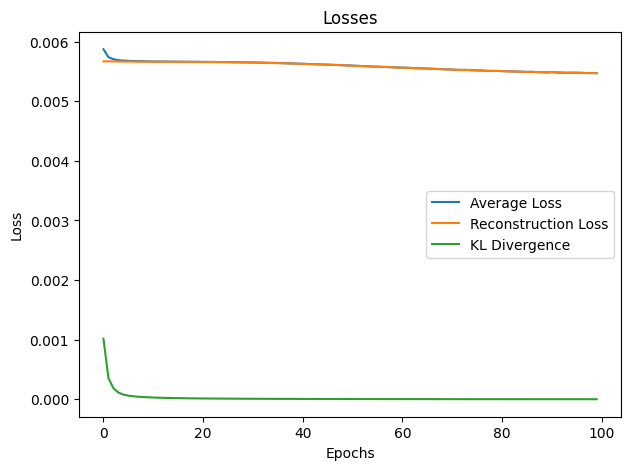

In [81]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 512  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 24  # modify as needed
hidden_dim2 = 128  # modify as needed
hidden_dim3 = 512  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 100  # modify as needed
beta = 0.2
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

    
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [82]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_data = batch[0]  # get the data from the batch

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div

In [83]:
evaluate(model, loss_fn, test_loader)

(tensor(0.0055), 0.005478294690450033, 4.403412342071533e-06)

# see the output

In [84]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_data = batch[0]  # get the data from the batch
            batch_data = batch_data.view(batch_data.size(0), -1)  # flatten the data
            reconstructed_batch, _, _ = model(batch_data)  # get reconstructed data from the model

            # Convert tensors to numpy arrays for use in pandas
            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()

            # Convert to dataframes
            original_df = pd.DataFrame(original_data)
            reconstructed_df = pd.DataFrame(reconstructed_data)

            if i == 0:  # for the first iteration, create the dataframes
                all_original_df = original_df
                all_reconstructed_df = reconstructed_df
            else:  # for subsequent iterations, append to the existing dataframes
                all_original_df = pd.concat([all_original_df, original_df])
                all_reconstructed_df = pd.concat([all_reconstructed_df, reconstructed_df])
    
    return all_original_df, all_reconstructed_df

# Call the function after training
original_df, reconstructed_df = test_model(model, test_loader)


In [85]:
original_df, reconstructed_df = test_model(model, valid_loader)

In [74]:
original_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.011059,-0.000688,-0.050495,0.006283,-0.078168,0.060976,-0.020656,0.064324,-0.039187,-0.050386,...,1.0,1.0,0.014331,0.041990,0.062897,0.056659,0.083365,-0.010076,0.019453,0.042835
1,0.045093,0.357293,-0.052318,0.023984,-0.079437,-0.064630,-0.177694,0.068332,-0.378153,0.679334,...,1.0,1.0,0.054762,-0.094758,-0.066864,-0.062517,0.042597,0.058450,-0.020841,-0.082203
2,-0.160763,-0.478253,-0.058969,0.097277,0.062118,0.049360,0.098586,0.029956,0.336544,-0.803452,...,-1.0,-1.0,-0.026777,-0.089011,0.047432,0.010113,0.057112,0.007800,0.036619,0.090570
3,-0.107175,-0.017778,-0.014382,-0.102119,-0.068903,0.077682,-0.169880,0.222112,-0.227179,0.079730,...,1.0,1.0,-0.090422,0.019275,0.052264,-0.057086,0.088505,-0.072535,0.028086,-0.084547
4,-0.070361,-0.143880,0.034461,-0.046620,0.032937,0.073360,-0.013014,0.043715,0.041883,-0.177599,...,-1.0,-1.0,0.061401,0.023023,0.031521,0.008483,-0.076748,-0.053662,0.093354,0.039162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.024271,0.269351,0.030346,-0.108444,0.017094,0.045980,-0.280763,0.086119,-0.510671,0.686397,...,1.0,1.0,-0.028665,-0.022193,-0.024839,0.032969,-0.068215,-0.058599,0.040410,-0.064413
1496,0.052785,0.431704,-0.030989,-0.042440,-0.077689,0.068527,-0.273509,0.046213,-0.481031,0.818665,...,1.0,1.0,-0.000708,-0.014953,-0.007984,0.036514,-0.034901,-0.094439,0.000687,-0.019684
1497,0.315469,0.133743,0.041914,-0.077078,-0.016236,-0.014397,0.399908,-0.372134,0.599839,-0.214021,...,1.0,1.0,0.083061,-0.049630,0.042368,-0.011017,-0.008690,-0.014742,-0.058104,0.092201
1498,-0.292754,0.437095,0.106727,0.073418,-0.045534,0.004260,-0.641362,0.530807,-1.183831,1.476218,...,1.0,1.0,-0.049516,-0.019234,0.050568,0.080669,0.092384,0.048941,-0.009779,0.052942


In [75]:
reconstructed_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.124533,-0.221424,-0.145173,-0.006669,0.063243,0.045073,-0.002548,0.016390,0.214668,0.073106,...,-0.036898,-0.105363,-0.107297,0.008659,0.003418,-0.197312,-0.252470,-0.003405,-0.167395,-0.031711
1,0.143480,-0.236546,-0.147356,-0.005368,0.055398,0.063121,0.008028,0.014522,0.239360,0.095556,...,-0.036838,-0.113048,-0.098176,0.025062,0.005454,-0.214869,-0.250675,0.008712,-0.173689,-0.022418
2,0.117838,-0.221106,-0.151592,0.002418,0.064035,0.058014,0.003266,0.009824,0.227006,0.079053,...,-0.040504,-0.109898,-0.104012,0.019449,0.020691,-0.194554,-0.238752,-0.006838,-0.152358,-0.031241
3,0.137774,-0.225573,-0.124276,-0.006233,0.059225,0.050032,0.008888,0.004686,0.234306,0.080525,...,-0.037641,-0.116229,-0.104199,0.016427,0.001712,-0.189548,-0.249141,0.009519,-0.172564,-0.040607
4,0.121470,-0.217610,-0.154930,-0.004923,0.065214,0.054882,0.001528,0.015187,0.224034,0.076585,...,-0.035356,-0.111160,-0.107284,0.017672,0.014443,-0.205738,-0.238729,-0.009276,-0.154542,-0.026898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.119869,-0.230728,-0.137974,-0.001430,0.056711,0.060908,0.005253,0.007011,0.229571,0.084427,...,-0.041824,-0.119357,-0.100939,0.015616,0.018071,-0.194115,-0.247263,-0.004955,-0.165272,-0.032881
1496,0.121795,-0.223846,-0.136487,-0.013410,0.054272,0.056706,0.006234,0.010387,0.225961,0.081148,...,-0.031490,-0.123471,-0.105050,0.011833,0.011488,-0.201982,-0.247420,-0.003588,-0.179777,-0.024024
1497,0.121235,-0.223205,-0.139051,-0.005722,0.056424,0.059435,0.001663,0.009899,0.226712,0.077830,...,-0.036718,-0.116827,-0.101447,0.011724,0.010749,-0.202411,-0.250035,-0.006259,-0.168359,-0.024304
1498,0.126403,-0.216812,-0.154240,-0.006568,0.063909,0.055246,-0.002241,0.013896,0.227570,0.075144,...,-0.038583,-0.109065,-0.108984,0.017229,0.010278,-0.207190,-0.244005,-0.009151,-0.158818,-0.022735


In [86]:
# Get the first row from the dataframe
first_row = reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
recon_combined_tensor = torch.tensor(reshaped_df.values)


In [51]:
replay(reshaped_df)

/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Swimmer-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


0   -0.139926
1    0.157584
Name: 0, dtype: float32
Creating window glfw


2023-07-27 13:21:40.365 python[44547:2923270] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


0    0.073389
1   -0.158975
Name: 1, dtype: float32
0    0.116139
1    0.107686
Name: 2, dtype: float32
0   -0.114843
1   -0.017716
Name: 3, dtype: float32
0   -0.043089
1    0.104847
Name: 4, dtype: float32
0    0.063043
1   -0.052748
Name: 5, dtype: float32
0    0.219888
1    0.087516
Name: 6, dtype: float32
0   -0.130604
1   -0.199224
Name: 7, dtype: float32
0    0.010136
1   -0.156759
Name: 8, dtype: float32
0   -0.07679
1    0.03554
Name: 9, dtype: float32
0   -0.055452
1    0.020870
Name: 10, dtype: float32
0    0.186233
1    0.037425
Name: 11, dtype: float32
0   -0.144864
1   -0.284767
Name: 12, dtype: float32
0    0.006366
1   -0.040872
Name: 13, dtype: float32
0   -0.205486
1    0.178008
Name: 14, dtype: float32
0   -0.201864
1   -0.031993
Name: 15, dtype: float32
0   -0.264236
1   -0.218248
Name: 16, dtype: float32
0    0.025881
1   -0.167981
Name: 17, dtype: float32
0   -0.029662
1    0.221602
Name: 18, dtype: float32
0   -0.182867
1   -0.103092
Name: 19, dtype: float32
0   

SystemExit: 0

/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [87]:
# Get the first row from the dataframe
first_row = original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
ori_combined_tensor = torch.tensor(reshaped_df.values)


In [ ]:
replay(ori_combined_tensor)

In [26]:
recon_combined_tensor-ori_combined_tensor

tensor([[-0.1198, -0.1550,  0.4563,  ..., -0.1441,  0.6658, -0.5765],
        [ 1.1892, -0.3707, -0.1260,  ..., -1.6430,  2.8639, -2.4233],
        [ 0.8910,  1.0391, -0.2096,  ..., -1.5129,  2.9911, -1.2082],
        ...,
        [-1.3420, -1.0858, -0.3244,  ...,  2.4165, -3.8592, -0.2681],
        [-1.0497, -0.8429, -0.3485,  ...,  2.6913, -3.2114, -0.9843],
        [-0.7667, -0.7755, -0.0154,  ...,  0.2855, -0.1879,  0.0838]])

In [88]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


tensor(159.2569)


6

# VRNN

In [23]:
import torch
from torch import nn

class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers, dropout=0.):
        super(VRNN, self).__init__()

        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers

        self.encoder = nn.LSTM(x_dim + h_dim, z_dim, n_layers, dropout=dropout)
        self.decoder = nn.LSTM(z_dim + h_dim, x_dim, n_layers, dropout=dropout)
        self.hidden_to_hidden = nn.Linear(z_dim, h_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = torch.zeros(self.n_layers, x.size(1), self.h_dim).to(x.device)

        for t in range(x.size(0)):
            _, h = self.encoder(torch.cat([x[t], h[-1]], -1).unsqueeze(0), h)
            mu, log_var = h.chunk(2, -1)
            z = self.reparameterize(mu, log_var)
            _, h = self.decoder(torch.cat([z, h[-1]], -1).unsqueeze(0), h)
            h = self.hidden_to_hidden(h)

        return h


In [29]:
# Define the data loader
batch_size = 512  # adjust as necessary
seq_length = 1000  # sequence length

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer, and loss function
model = VRNN(x_dim=10, h_dim=128, z_dim=20, n_layers=2, dropout=0.2)

optimizer = optim.Adam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function

# Training
for epoch in range(1, n_epochs + 1):
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch  # get the data from the batch
        
        optimizer.zero_grad()

        h = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(h, batch_data)
        loss = recon_loss  # modify this line to include KL divergence

        loss.backward()
        optimizer.step()

    print(f'====> Epoch: {epoch} Loss: {loss.item()}')


RuntimeError: For batched 3-D input, hx and cx should also be 3-D but got (2-D, 2-D) tensors

In [27]:
for i, batch in enumerate(train_loader):
    batch_data = batch
    print(batch_data.shape)
    break


AttributeError: 'list' object has no attribute 'shape'

# render with action

In [45]:

import torch

# Convert combined_arr to PyTorch Tensor
# combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

import matplotlib.pyplot as plt
from IPython import display
import gym


def replay(combined_data):

    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v3', render_mode = 'human')

    # Iterate through the rows
    for i in range(len(action_sp)):
        # Get the i-th row
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]
        print(action)

        # If this is the first iteration, set the environment state to the given observation
        # Note: This assumes that the observation you've stored is the entire state that can be set with `env.reset()`
        # If this is not the case, you cannot simply set the environment state to the observation
        if i == 0:
            env.reset()  # We ignore the initial observation returned by `reset`

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        # Render the environment
        env.render()
        # If you want to slow down each step for viewing, you can use time.sleep
        # time.sleep(0.01)

    # Close the environment
    env.close()


torch.Size([10000, 1000, 10])


In [ ]:
action_sp